In [1]:
import torch
# import torch_xla.core.xla_model as xm
import os
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
dev = None
# if os.environ['COLAB_TPU_ADDR']:
#   dev = xm.xla_device()
if torch.cuda.is_available():
  dev = torch.device('cuda')
else:
  dev = torch.device("cpu")
print(f"Using device '{dev}'")


from PIL import Image
from torch.nn.functional import softmax
from torchvision import models, transforms, datasets
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import copy
import json
import requests

Torch 2.6.0 CUDA 12.2
Device: cuda:0
Using device 'cpu'


/home/bransthr/.envs/csc2529/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at /shared_tmp/build_wheels_tmp.115664/python-3.11/torch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Try alien notebook for setting resnet up

In [2]:
!wget https://caballerojose.com/images/blas.jpg -P blas_the_dog/test

--2025-11-15 15:20:16--  https://caballerojose.com/images/blas.jpg
Resolving caballerojose.com... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to caballerojose.com|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221678 (216K) [image/jpeg]
Saving to: ‘blas_the_dog/test/blas.jpg.1’

blas.jpg.1          100%[===================>] 216.48K  --.-KB/s    in 0.04s   

2025-11-15 15:20:16 (5.82 MB/s) - ‘blas_the_dog/test/blas.jpg.1’ saved [221678/221678]



In [10]:
def class_name_to_id(class_name):
  """
  Maps ImageNet class name to ID number between 0 and 1000 (exclusive)
  E.g. class_name_to_id('Border Collie') -> int
  """
  imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
  response = requests.get(imagenet_labels_url)
  class_names = json.loads(response.text)
  for i, cn in enumerate(class_names):
    if cn == class_name:
      return i
  return None

def class_id_to_name(class_id):
  """
  Maps ImageNet class ID back to it's canonical class name
  """
  imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
  response = requests.get(imagenet_labels_url)
  class_names = json.loads(response.text)
  return class_names[class_id]

def top_5_classes(y, class_names = None):
  """
  y : tensor([1, 1000])
    The output of the model, e.g. from running `model(to_tensor(x))`. The values
    are normalized in this function by using softmax to convert them to probabilities.
  """
  y = torch.Tensor.cpu(y)
  if class_names==None:
    imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(imagenet_labels_url)
    class_names = json.loads(response.text)
  p = softmax(y[0,:], dim=0)
  values, indices = p.topk(5)
  return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

def probability_of_class(y, label):
  """
  If y is the output of a resnet model or similar, and label is an imagenet
  label, either the canonical name as a string, or an integer id, the model's
  confidence in classifying the output as `label` is returned.
  """
  y = torch.Tensor.cpu(y)
  if isinstance(label, str):
    label = class_name_to_id(label)
  if torch.is_tensor(label):
    label = int(torch.Tensor.cpu(label).detach().numpy())
  p = softmax(y[0,:], dim=0)
  return p[label].detach().numpy()

def autolabel(rects, ax, labels):
  """
  Auxiliary function to `plot_prediction`.

  Attach a text label above each bar displaying its height.
  See https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
  """
  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            label, ha='left', va='bottom', rotation=45)
        
def plot_prediction(x, y, ax_img=None, ax_bar=None, title=None):
  """
  Visualises the input image along with the top 5 classifications of the model.

  Attributes
  ------------------
  x : PIL image
    The input image
  y : tensor([1, 1000])
    The output of the model, e.g. from running `model(to_tensor(x))`
  """
  y = torch.Tensor.cpu(y)
  fig = None
  if ax_img is None or ax_bar is None:
    fig, axs = plt.subplots(ncols=2,figsize=(10,5))
  if title is not None:
    assert fig is not None
    fig.suptitle(title, fontsize=18)
  top_classes_str = ' '.join([f"{n} ({p:.3})" for n, p in top_5_classes(y)])
  title = f"Top classes: {top_classes_str}"
  # ax.set_title(title)
  axs[0].imshow(x)
  axs[0].axis('off')
  axs[0].set_title("Input image")
  ps = [p[1] for p in top_5_classes(y)]
  names = [p[0] for p in top_5_classes(y)]
  rects = axs[1].bar(np.arange(5), ps)
  if max(ps) > 0.9:
    axs[1].set_ylim([0.0, max(ps)+0.3])
  else:
    axs[1].set_ylim([0.0, max(ps)+0.1])
  autolabel(rects, axs[1], names)
  axs[1].set_title("Confidence for top 5 classes")


In [11]:
class_id_to_name(731)

'plunger'

In [4]:
resnet50 = models.resnet50(pretrained=True).to(dev)
resnet50.eval()

/home/bransthr/.envs/csc2529/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bransthr/.envs/csc2529/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# these operations are not autograd differentiable, so we apply them before
#   feeding the input into the model
input_transform = transforms.Compose([transforms.Resize(255),
                                  transforms.CenterCrop(224) # 224 x 224
                                  ])
                         
class transform_layer(nn.Module):
  """
  Applies normalization according to https://pytorch.org/vision/0.8/models.html
  """
  def __init__(self):
    super(transform_layer, self).__init__()
    self.normalize_transform = transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]
                        )
    self.to_tensor = transforms.ToTensor()

  def forward(self, x):
    # apply the input_transform if it has not already been applied
    if not torch.is_tensor(x) and x.size != (224, 224):
      x = input_transform(x)
    # covert to tensor if not already done
    if not torch.is_tensor(x):
      x = self.to_tensor(x)

    x = x.to(dev)
    # then normalize
    x = self.normalize_transform(x)
    # add batch number
    if len(x.size()) == 3:
      return x.unsqueeze(0)
    else:
      return x

model = copy.deepcopy(resnet50)
# prepend the transformation
model = nn.Sequential(transform_layer(), model)

In [6]:
# transformations
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

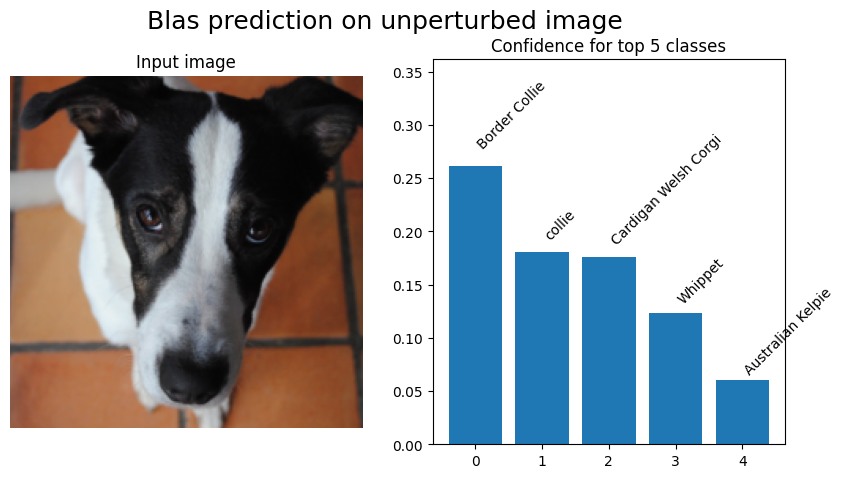

In [12]:
blas_img = Image.open("blas_the_dog/test/blas.jpg")
blas_img = input_transform(blas_img)
y = model(blas_img)
plot_prediction(blas_img, y, title="Blas prediction on unperturbed image")

In [13]:
from typing import Any
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import glob
import pandas as pd
import io

class CustomDataset(Dataset):

  def __init__(self, path: Path, split : str, frac : float = None):
    """
    Attributes
    -------------
    path : Path
      A Path object pointing to the root of the data
    split : str
      A string. Must be one of "val", "test" and "train"
    frac : float
      A value between 0.0 and 1.0. If specified, only this fraction of the found
      data will be used to create the dataset, and the dataset is shuffled before
      doing so.
    """
    assert path.exists()

    # save for __getitem__ later
    self.path = path
    
    # create the csv of all of our files, ignoring already set up eval,val,train split
    csv_files = list(glob.glob(str(path / f"labels/{split}.csv")))
    # csv_files = list(glob.glob(str(path / "labels/*.csv")))
    data_df = pd.concat([pd.read_csv(f) for f in csv_files])

    # Figure out the mappings from the confusing "n01855672"-like labels
    imagenet_label_map_url = "https://raw.githubusercontent.com/mf1024/ImageNet-Datasets-Downloader/master/classes_in_imagenet.csv"
    response = requests.get(imagenet_label_map_url)
    class_names_df = pd.read_csv(io.StringIO(response.content.decode('utf-8'))).set_index('synid')

    # add label column to original dataframe, which previously had "n\d+" labels
    data_df['class_label'] = data_df.apply(lambda x : class_names_df.loc[x[1]][0], axis=1)

    # then also map to IDs
    imagenet_label_map_url = "https://raw.githubusercontent.com/akshaychawla/ImageNet-downloader/master/imagenet_class_index.json"
    response = requests.get(imagenet_label_map_url)
    class_ids = json.loads(response.text)
    # map from label to ID instead
    self.class_id = {}
    for k in class_ids.keys():
      self.class_id[class_ids[k][0]] = int(k)
    
    # save for later
    if frac is None:
      self.df = data_df
    else:
      # shuffle the dataset of a fraction is used
      self.df = data_df.sample(frac=frac).reset_index(drop=True)

    # transform function
    self.to_tensor = transforms.ToTensor()

  def __len__(self) -> int:
    # can do len(dataset)
    return self.df.shape[0]

  def __getitem__(self, index: int) -> Any:
    row = self.df.iloc[index]
    # use pillow to load the images, like we did for Blas, then crop and centre
    image = input_transform(Image.open(self.path / f"images/{row['filename']}"))
    # we created meaningful labels in __init__, so use these
    class_label = str(row['label'])
    # convert to tensors
    return self.to_tensor(image), torch.tensor(self.class_id[class_label])

  def get_dataframe(self):
    return self.df

def get_dataset(split, frac=None):
  assert split in ["train", "val", "test"]
  return CustomDataset(Path("./dataset/mini-imagenet/"), split, frac)

In [14]:
data = get_dataset("val")
print(f"Validation dataset has {len(data)} items")
data.get_dataframe().head()

/tmp/ipykernel_2553504/2905306451.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_df['class_label'] = data_df.apply(lambda x : class_names_df.loc[x[1]][0], axis=1)


Validation dataset has 9600 items


,filename,label,class_label
0,n0185567200000003.jpg,n01855672,goose
1,n0185567200000004.jpg,n01855672,goose
2,n0185567200000010.jpg,n01855672,goose
3,n0185567200000013.jpg,n01855672,goose
4,n0185567200000016.jpg,n01855672,goose


In [10]:
# to demonstrate shuffling
get_dataset("train", 0.01).get_dataframe().head()

/tmp/ipykernel_2872413/2905306451.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_df['class_label'] = data_df.apply(lambda x : class_names_df.loc[x[1]][0], axis=1)


,filename,label,class_label
0,n0438903300000737.jpg,n04389033,tank
1,n0459674200001092.jpg,n04596742,wok
2,n0209183100000154.jpg,n02091831,Saluki
3,n0184338300000443.jpg,n01843383,toucan
4,n0333714000000377.jpg,n03337140,file


In [11]:
def evaluate_model(model, data, noise=None, criterion=nn.CrossEntropyLoss(reduction='sum'),
                   batchsize=50, stop_after=100000, model_name=None, target_label=None):
  """
  Evaluates the model's performance in terms of loss, top-1 accuracy and top-5 accuracy
  on images from the data, adding the same `noise` to all the images if
  it is specified.

  Attributes:
  -----------------
  model : nn.Module
    The imagenet-trained module. Should be of shape:
    tensor([x, 3, 224, 224]) -> tensor([x, 1000])
  data : Dataset
    The data to evaluate on
  stop_after : int
    Only does this many batches before stopping the evaluation. Used to limit computation time.
  model_name : str
    If specified, the returned dataframe has an index with the model name in it
  target_label : str
    If specified, evaluation is done in terms of how successfully the specified
    noise can perturb the classification to predict `target_label`
  noise : tensor([3, 224, 224])
    Noise to be applied to each of the input images in `data`
  criterion : fun : tensor([x, 1000]) , tensor([x, 1]) -> tensor([1])
    Loss function to base evaluation on
  """
  with torch.no_grad():
    cumulative_loss = torch.zeros([1]).to(dev)
    correct_top1s = 0
    correct_top5s = 0

    # temporaily put model in GPU
    model = model.to(dev)

    if target_label is not None:
      target_label = torch.scalar_tensor(class_name_to_id(target_label)).type(torch.LongTensor).to(dev)

    # repeat the noise, once for each image in the batch
    if noise is not None:
      noise = noise.unsqueeze(0).repeat(batchsize, 1, 1, 1)
      noise = noise.to(dev)

    dataloader = DataLoader(data, batch_size=batchsize, shuffle=True, drop_last=True)
    for i, (imgs, labels) in enumerate(dataloader):
      torch.cuda.empty_cache()
      # move to GPU if we use one
      imgs = imgs.to(dev)
      labels = labels.to(dev)

      if noise is not None:
        imgs = torch.clamp(imgs + noise, 0 , 1)
  
      # make prediction
      out = model(imgs).detach()
      p = softmax(out, dim=1)
      _, predict_labels = p.topk(5)
  
      # iterate our batch and count correct predictions
      for lab, pred in zip(labels, predict_labels):
        # We are doing a targeted attack, so evaluate based on how successful that is
        if target_label is not None:
          lab = target_label
        # top-5
        if lab in pred:
          correct_top5s += 1
        # top-1
        if lab == pred[0]:
          correct_top1s += 1
      # accumlate loss
      cumulative_loss += criterion(out, labels)
  
      if i == stop_after - 1:
        break
  
    # aggregate
    num_datapoints = min(batchsize * stop_after, len(data))
    cumulative_loss /= num_datapoints
    correct_top1s /= num_datapoints
    correct_top5s /= num_datapoints

    # make sure model is removed from GPU memory
    # model = model.cpu()
    
    # format result in nice dataframe
    row_entries = [cumulative_loss.item(), correct_top1s, correct_top5s]
    column_names = ["Loss", "Top-1 Accuracy", "Top-5 Accuracy"]
    # we are evaluating how often we can get the target label in top 1/5
    if target_label is not None:
      column_names = ["Loss", "Top-1 Success rate", "Top-5 Success rate"]
    if model_name is not None:
      return pd.DataFrame([[model_name] + row_entries], columns = ["Model"] + column_names).set_index('Model')
    else:
      return pd.DataFrame([row_entries], columns = column_names)

In [ ]:
torch.cuda.empty_cache()
# min(50 * 100, 9600) data images tested on
unperturbed_eval = evaluate_model(model, data, batchsize=50, stop_after=100)
unperturbed_eval

## Try Torchattack

In [2]:
import torchattacks

In [15]:
example_dataloader = DataLoader(data, batch_size=1, shuffle=True, drop_last=True)
for x_example, y_example in example_dataloader:
    break

In [15]:
x_example = x_example.to(dev)
y_example = y_example.to(dev)
x_example, y_example

(tensor([[[[0.4667, 0.4471, 0.4314,  ..., 0.3176, 0.3294, 0.3216],
           [0.4549, 0.4510, 0.4392,  ..., 0.3020, 0.3137, 0.3216],
           [0.4471, 0.4431, 0.4314,  ..., 0.2980, 0.3137, 0.3216],
           ...,
           [0.3725, 0.3373, 0.2196,  ..., 0.5608, 0.5569, 0.4392],
           [0.3490, 0.2941, 0.1882,  ..., 0.6627, 0.6549, 0.3098],
           [0.3059, 0.2314, 0.1451,  ..., 0.7608, 0.5216, 0.3608]],
 
          [[0.6431, 0.6235, 0.6078,  ..., 0.4863, 0.4980, 0.4902],
           [0.6314, 0.6275, 0.6157,  ..., 0.4706, 0.4824, 0.4902],
           [0.6235, 0.6196, 0.6078,  ..., 0.4667, 0.4824, 0.4902],
           ...,
           [0.6039, 0.5529, 0.4275,  ..., 0.6549, 0.6745, 0.6000],
           [0.5725, 0.4706, 0.3137,  ..., 0.7569, 0.7412, 0.4196],
           [0.5020, 0.3765, 0.2353,  ..., 0.8471, 0.5922, 0.4588]],
 
          [[0.4275, 0.4000, 0.3765,  ..., 0.3059, 0.3176, 0.3098],
           [0.4157, 0.4039, 0.3843,  ..., 0.2902, 0.3020, 0.3098],
           [0.4078, 0.39

In [16]:
tk = torchattacks.PGD(model, eps=0.03, alpha=0.005, steps=40)

In [17]:
true_y_repr = torch.zeros(1, 1000).to(dev)
true_y_repr[0, y_example] = 1.0

In [18]:
x_example.shape, y.shape, true_y_repr.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 1000]), torch.Size([1, 1000]))

In [ ]:
adv_image = tk(x_example, true_y_repr)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

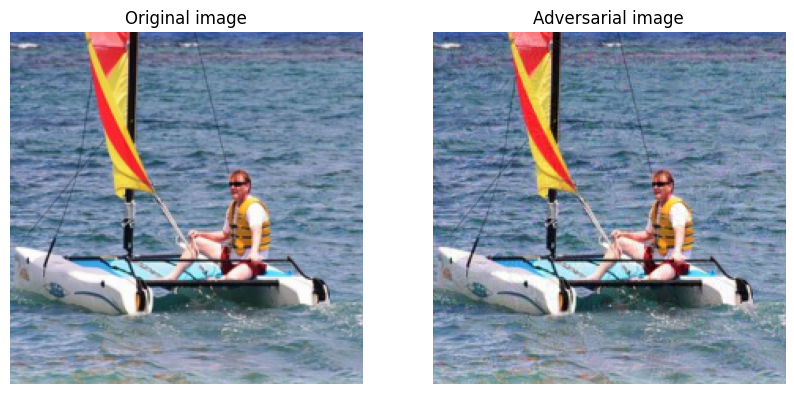

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(to_pil(x_example.squeeze(0).cpu()))
ax[0].set_title("Original image")
ax[0].axis('off')
ax[1].imshow(to_pil(adv_image.squeeze(0).cpu()))
ax[1].set_title("Adversarial image")
ax[1].axis('off')

In [20]:
y_adv = model(adv_image)
plot_prediction(to_pil(adv_image.squeeze(0).cpu()), y_adv, title="Adversarial image prediction")

NameError: name 'adv_image' is not defined

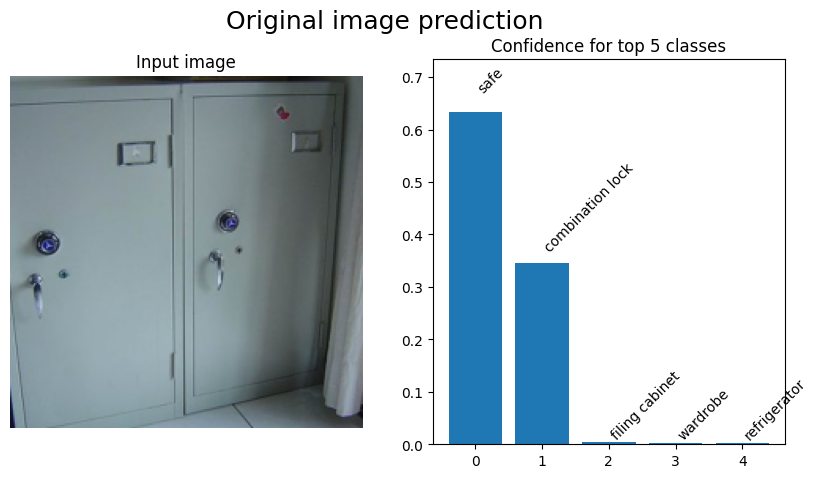

In [21]:
y_original = model(x_example)
plot_prediction(to_pil(x_example.squeeze(0).cpu()), y_original, title="Original image prediction")

In [24]:
y_original.argmax(), y_example

(tensor(771), tensor([507]))

In [30]:
x_example.min(), x_example.max()

(tensor(0.0196), tensor(0.9176))

In [31]:
class_id_to_name(173), class_id_to_name(280)

('Ibizan Hound', 'grey fox')